In [1]:
# When kernel error appears, type python ipykernel -m install --user

import numpy as np
from matplotlib import pyplot as plt
import hdf5storage
import mpld3
mpld3.enable_notebook() # allows zooming in plots
from matplotlib import gridspec as gridspec
import matplotlib as mpl
import math
import scipy
from scipy.optimize import curve_fit
%matplotlib inline
from scipy import signal as sig
from shapely.geometry import Polygon
import uncertainties as unc
import uncertainties.unumpy as unp

In [2]:
# Load data
tg = False
dFF_flag = True # If false, the CNMF spiking matrix S is used. 
            # Note, at in the Code it is still called dFF..

if tg == True:
    if dFF_flag == False:
        pathname = '_Recordings_tg/'
    else:
        pathname = 'dFF/_Recordings_tg/'
    filenames = ['95_PY_PRE.mat','210_PY3_PRE.mat','218_PY3_PRE.mat']
else:
    if dFF_flag == False:
        pathname = '_Recordings_wt/'
    else:
        pathname = 'dFF/_Recordings_wt/'          
    filenames = ['93_PY.mat','94_PY_PRE.mat','253_PY.mat']



for fileindex in range(0,3):    # Adjust to which files you want to have in your workspace
    
        
    if dFF_flag == True:
        if not 'dataDff'+str(fileindex) in globals():
            globals() ['dataDff'+str(fileindex)] = hdf5storage.loadmat(pathname + filenames[fileindex])
        else:
            print('already loaded')
        
    else:
        
        if not 'dataS'+str(fileindex) in globals():
            globals() ['dataS'+str(fileindex)] = hdf5storage.loadmat(pathname + filenames[fileindex])
        else:
            print('already loaded')
 

In [3]:
fileindex = 0

if dFF_flag == True:
    dFF = np.array(globals() ['dataDff'+str(fileindex)]['dFF_samp']) 
    pos = np.array(globals() ['dataDff'+str(fileindex)]['pos'])*360/9
    lap = np.array(globals() ['dataDff'+str(fileindex)]['lap'])
else: 
    dFF = np.array(globals() ['dataS'+str(fileindex)]['dFF_samp'])
    pos = np.array(globals() ['dataS'+str(fileindex)]['pos'])
    lap = np.array(globals() ['dataS'+str(fileindex)]['lap'])
    

In [4]:
# Define parameters for place Cell identification:

lengthBelt = max(pos)*2 

# MAKE SCALING IN CM FROM BEGINNING ON AND ONLY WORK WITH THIS THEN: 

widthOfBin = lengthBelt/46  #in cm.
print('width of Bin = '+str(widthOfBin)+'cm')

posBin = np.arange((min(pos)),(max(pos)),widthOfBin) 
numCells = int(len(dFF))
v_thresh = 2
numLaps = int(max(lap))
numBins = len(posBin)-1
run_only = True #Determines if signal is only binned, when mouse is running
print('numBins = '+str(numBins))

width of Bin = [7.80877997]cm
numBins = 46


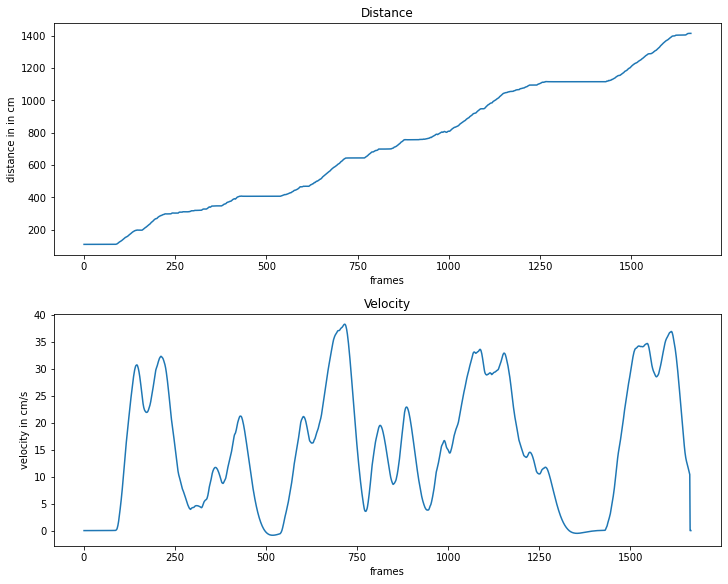

In [5]:
# Calculate speed of mouse indirectly with Kalman filter: 

# construct new pos array for Kalman filter, because position for one lap is recorded from -180 cm to 180 cm
# i.e. the position vector jumps from -180 cm to 180 cm at the 'seam' of the belt, i.e. in one timestep.
# Due to the spot where this seam is, the Kalman filter would interpolate a super high speed if we dind't transform
# the position in terms of continuing with 181 cm... after 180 cm instead of -180 cm.


idx = []
pos1 = pos+abs(min(pos))
for k in range(0,len(pos)-1):
    if pos[k]>4 and pos[k+1]<-4:
        idx.append(k)
idx.append(len(pos1))
        
pos2 = []

for k in range(0,len(idx)):
    if k == 0: 
        pos2.append(pos1[0:idx[k]].tolist())
    else: 
        pos2.append(np.array(pos1[idx[k-1]+1:idx[k]]+pos2[k-1][len(pos2[k-1])-1]).tolist())

pos2 = np.concatenate(pos2).flatten() 


# One predicts both position and velocity and then compares it with real measured position to update your prediction 
# for the state, which also includes the speed.

# Unit of speed is cm/s and unit of position is cm.

# Initialize mean of state variable x. 
# First row is initial position and second row is initial velocity. 
x = np.array([[pos2[0]],[0]])

# initialize covariance of x: 
P = np.array([[1,0],[0,100]])

# time step = 1/Framerate
dt = 0.05 #seconds


# Following physics, the prediction is: mean(pos') = mean(pos)*v*dt and mean(v') = mean(v)+mean(1/2*a*dt^2). 
# Approximation: a (which we don't know) comes from a normal distribution around 0 with variance 1. 
# --> prediction for updated mean of state GRV-> x' = F*x

# Prediction for updated covariance of state x: 
# P' = F*P*F_trans + G*G_trans where G = [[1/2*dt^2],[dt]] ,  G*G_trans = Q

F = np.array([[1,dt],[0,1]]) #'Transition'-Matrix

Q = np.array([[1/4*dt**4,1/2*dt**3],[1/2*dt**3,dt**2]])

H = np.array([1,0]).reshape(1,2) #measurement function: We only measure position

I = np.eye(2) #2D identity matrix

R = np.array([1**(-3)]) # variance of measurement noise 

posF = np.zeros(len(pos))
vF = np.zeros(len(pos))




for k in range(0,len(pos2)):
    
    # Prediction step (See explanation above):
    x = F.dot(x)
    P = F.dot(P).dot(F.T)+Q
    
    # Measurement step (Incorporate knowledge about real position to update prediction.
    # It's done for every measurement, i.e. every frame):
    z = pos2[k]
    y = z -H.dot(x) # 'Innovation' between mean state prediction and measurement (we only measure position)
    S = (H.dot(P).dot(H.T)+R) # Innovation-covariance with measurement-covariance/ uncertainty R.
    
    K = P.dot(H.T)*np.linalg.inv(S) # 'Kalman-Gain'= Kalman Gain = Uncertainty in predicted state divided by
    #(Uncertainty in predicted state + Uncertainty in measurement readings). So update is weighted more when the 
    # measurement uncertainty is small. 
    
    
    # Update step: 
    x = x+(K.dot(y))
    P=(I-K.dot(H)).dot(P)
    
    
    posF[k] = x[0] # can be used to test the initializazion
    vF[k] = x[1]

v = vF # Speed in cm/s
distance = pos2

#plot runned distance and velocity
fig = plt.figure(constrained_layout = True,figsize=(10,8))
ax = fig.add_gridspec(2,1)
ax1 = fig.add_subplot(ax[0,0:2])
ax2 = fig.add_subplot(ax[1,0:2])
ax1.set_title('Distance')
ax1.plot(distance)
ax1.set_xlabel('frames')
ax1.set_ylabel('distance in in cm')
ax2.set_title('Velocity')
ax2.set_xlabel('frames')
ax2.set_ylabel('velocity in cm/s')
ax2.plot(v)



In [6]:
# Determine mean dFF in each bin in each lap. Also produce binned signal which is normalized with the duration per bin

def assign_dFF(dFF_signal):
    
    dFFInBinAll = np.zeros((numLaps,numBins))
    durInBinAll = np.zeros((numLaps,numBins))
    dFFInBinAllNormalized = np.zeros((numLaps,numBins))
    occupancy = [0]*numLaps
    
    for l in range(0,numLaps):
        
        for b in range(1,numBins+1):

            BinIdx1 = np.where(pos>posBin[b-1])[0]
            BinIdx = np.where(pos<posBin[b])[0]
            LapIdx = np.where(lap==l+1)[0]
            vIdx = np.where(v>v_thresh)[0]
            
            if run_only:
                Idx = list(set(BinIdx1).intersection(BinIdx,LapIdx,vIdx)) 
            else: 
                Idx = list(set(BinIdx1).intersection(BinIdx,LapIdx))
            
            
            dFFPerBin = dFF_signal[Idx]
            durPerBin = len(Idx)
            

            if durPerBin>0:     
                dFFInBinAll[l][b-1] = np.nanmean(dFFPerBin)
                durInBinAll[l][b-1] = durPerBin 
            else: 
                dFFInBinAll[l][b-1] = float('nan')
                durInBinAll[l][b-1] = 0
        
        occupancy[l] = np.array(durInBinAll[l])/sum(durInBinAll[l])
        dFFInBinAllNormalized[l] = dFFInBinAll[l]*occupancy[l]
        
        
    meanDFF = np.nanmean(dFFInBinAll,axis = 0) 
    meanDFFNormalized = meanDFF*np.nanmean(occupancy,axis = 0)    
    
    meanDur = np.nanmean(durInBinAll,axis = 0)

    return dFFInBinAll, dFFInBinAllNormalized, meanDFF, meanDFFNormalized, meanDur


In [7]:
#assign dFF for all cells:

dFFInBinAll = [0]*numCells
dFFInBinAllNormalized = [0]*numCells
meanDFF = [0]*numCells 
meanDFFNormalized = [0]*numCells
meanDur = [0]*numCells


for c in range(0,numCells):
    print('cell ' + str(c+1))
    dFFInBinAll[c], dFFInBinAllNormalized[c], meanDFF[c], meanDFFNormalized[c], meanDur[c] = \
    assign_dFF(dFF[c])

cell 1
cell 2
cell 3


<ipython-input-6-27d717aff330>:30: RuntimeWarning: Mean of empty slice
  dFFInBinAll[l][b-1] = np.nanmean(dFFPerBin)


cell 4
cell 5
cell 6
cell 7
cell 8
cell 9
cell 10
cell 11
cell 12
cell 13
cell 14
cell 15
cell 16
cell 17
cell 18
cell 19
cell 20
cell 21
cell 22
cell 23
cell 24
cell 25
cell 26
cell 27
cell 28
cell 29
cell 30
cell 31
cell 32
cell 33
cell 34
cell 35
cell 36
cell 37
cell 38
cell 39
cell 40
cell 41
cell 42
cell 43
cell 44
cell 45
cell 46
cell 47
cell 48
cell 49
cell 50
cell 51
cell 52
cell 53
cell 54
cell 55
cell 56
cell 57
cell 58
cell 59
cell 60
cell 61
cell 62
cell 63
cell 64
cell 65
cell 66
cell 67
cell 68
cell 69
cell 70
cell 71
cell 72
cell 73
cell 74
cell 75
cell 76
cell 77
cell 78
cell 79
cell 80
cell 81
cell 82
cell 83
cell 84
cell 85
cell 86
cell 87
cell 88
cell 89
cell 90
cell 91
cell 92
cell 93
cell 94
cell 95
cell 96
cell 97
cell 98
cell 99
cell 100
cell 101
cell 102
cell 103
cell 104
cell 105
cell 106
cell 107
cell 108
cell 109
cell 110
cell 111
cell 112
cell 113
cell 114
cell 115
cell 116
cell 117
cell 118
cell 119
cell 120
cell 121
cell 122
cell 123
cell 124
cell 125
cell

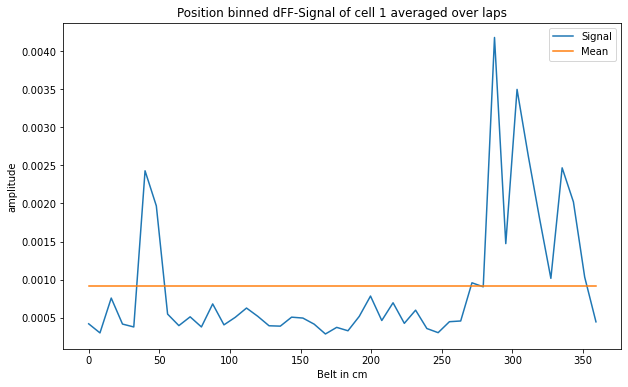

In [8]:
# plot the normalized binned signal for individual cells:

cellIdx = 1

plt.figure(figsize = (10,6))
plt.plot(np.linspace(0,lengthBelt,numBins),meanDFFNormalized[cellIdx],label ='Signal')
x = np.linspace(0,lengthBelt,numBins)
plt.plot(x,[np.mean(meanDFFNormalized[cellIdx])]*numBins,label='Mean')
plt.ylabel('amplitude')
plt.xlabel('Belt in cm')

if dFF_flag == True:
    plt.title('Position binned dFF-Signal of cell '+str(cellIdx) +' averaged over laps')
    plt.legend(loc='upper right')
else:
    plt.title('Position binned S-Signal of cell '+str(cellIdx) +' averaged over laps')
    plt.legend(loc = 'upper right')

In [9]:
# calculate placescore for each cell: 
def calculate_placescore(dFFPerBin,durPerBin):
        
        placescore = 0

        for i in range(1,numBins):
            
            occupancy = durPerBin[i]/sum(durPerBin[1:])

            incr = occupancy*(dFFPerBin[i]/np.nanmean(dFFPerBin))\
            *np.real(np.log2(dFFPerBin[i]/np.nanmean(dFFPerBin)))

            if not np.isnan(incr):
                placescore = placescore+incr
                
        return placescore

In [10]:
placeScore = [0]*numCells
occupancy=[0]*numCells
for c in range(0,numCells):
    placeScore[c] = calculate_placescore(meanDFF[c],meanDur[c])

In [11]:
## Polar Analysis:

# Put position binned siganl in a circle and calculate the centroid.
# If centroid is far from origin of polar coordinate system, it's likely that we have a placecell. 

def polar_analysis(dFFPerBin):
   
    dFFPerBin = dFFPerBin/np.nanmean(dFFPerBin) # normalize with mean of dFF per Bin

    nanidx = np.array(np.where(dFFPerBin==np.nan))

    # Interpolate for possible Nans. Otherwise polygon would be distorted and yield a misleading centroid
    t = np.linspace(0,2*np.pi,len(dFFPerBin))

    if not nanidx.size ==0:
        dFFPerBin[nanidx] = np.interp(t[nanidx],t[np.arange(len(t))!=nanidx].flatten(),\
                                   signal[np.arange(len(dFFPerBin))!=nanidx].flatten())

    # convert from polar to cartesian, because the polygon function requires cartesian coordinates.
    x = dFFPerBin*np.cos(t)
    y = dFFPerBin*np.sin(t)

    # calculate centroid and convert to polar coordinates to get rho:
    poly = Polygon(np.array([x,y]).T)
    centroid = poly.centroid # in cartesian coordinates
    
    #convert to polar coordinates to get rho and normalize with mean dFF signal of cell 
    centroidRho = np.sqrt(np.array(centroid)[0]**2+np.array(centroid)[1]**2)
    
    return poly,centroid,centroidRho

In [12]:
poly = [0]*numCells
centroid = [0]*numCells
centroidRho = [0]*numCells

for c in range(0,numCells):
    poly[c], centroid[c], centroidRho[c] = polar_analysis(meanDFFNormalized[c])

0.0009642121552024324


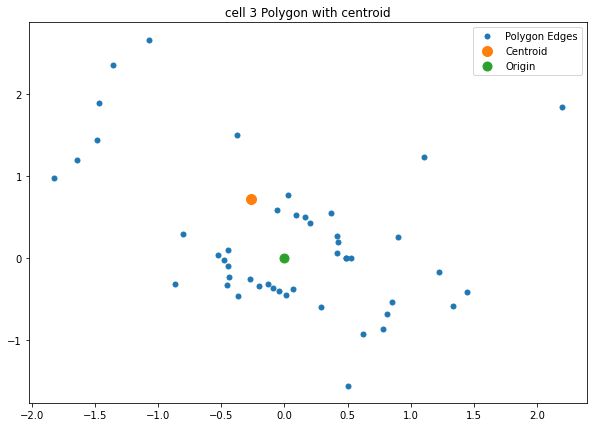

In [13]:
cellIdx = 3

plt.figure(figsize=(10,7))
plt.plot(*poly[cellIdx].exterior.xy,'.',label='Polygon Edges',markersize = 10)
plt.plot(np.array(centroid[cellIdx])[0],np.array(centroid[cellIdx])[1],'.',label = 'Centroid',markersize=20)
plt.plot(0,0,'.',label='Origin',markersize = 18)
plt.title('cell '+str(cellIdx)+' Polygon with centroid')
plt.legend()

print(np.mean(meanDFFNormalized[cellIdx]))

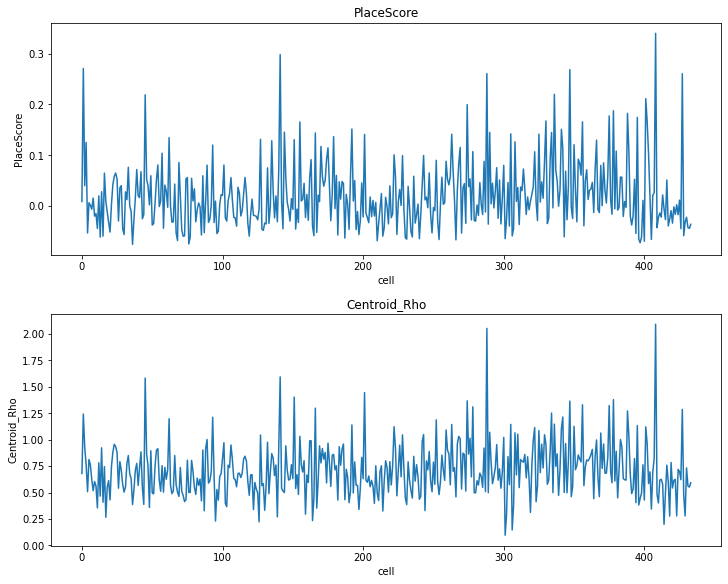

In [14]:
# Compare place score and rho across cells

fig = plt.figure(constrained_layout = True,figsize=(10,8))
ax = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(ax[0,0:2])
ax2 = fig.add_subplot(ax[1,0:2])
ax1.set_title('PlaceScore')
ax1.plot(placeScore)
ax1.set_xlabel('cell')
ax1.set_ylabel('PlaceScore')
ax2.set_title('Centroid_Rho')
ax2.set_xlabel('cell')
ax2.set_ylabel('Centroid_Rho')
ax2.plot(centroidRho)

In [15]:
# shuffle/ bootstrap to get percentile in the probability distribution that placescore was by chance:
# (when value is far out from distribution mean, i.e. percentile >0.95 it's most likely not a placeencoding by chance,
# i.e. we have a placecell.)

shift_minrange = 500
shift_maxrange = len(pos)
nshuffle = 100

shiftframes = [int(x) for x in np.around(((shift_minrange+np.random.rand(1,nshuffle)*\
                                           (shift_maxrange-shift_minrange))[0]),0)]

meandFFshuffled = np.zeros((nshuffle,len(dFF)))

placeScoreShuffled = np.zeros((numCells,nshuffle))
dFFInBinShuffled = np.zeros((int(max(lap)),numBins))

for c in range(0,numCells):
    print('cell ' + str(c+1))
    for n in range(0,nshuffle):

        #shift whole dFF for a random distance between 500 and len(pos)
        dFFShifted = np.roll(dFF[c],shiftframes[n])


        # Create (here n_laps*2) chunks of shifted dFF 
        # (the smaller the chunks the 'better shuffled')
        #Add such that array is dividible by 2*max(lap)
        
        filler = np.repeat(float('nan'),np.mod(-len(dFFShifted),int(2*max(lap)))) 
        dFFShiftedChunked = np.reshape(np.append(dFFShifted,filler),(int(2*max(lap)),-1))
        
        permutationIndices = np.random.permutation(int(2*max(lap)))
        
        dFFPermutedChunked = dFFShiftedChunked[permutationIndices][:]
          
        dFFPermuted = np.reshape(dFFPermutedChunked,(len(dFFShifted)+len(filler),-1))
        
        _ , _ , dFFInBinShuffled , _ , _ = assign_dFF(dFFPermuted)
        
        placeScoreShuffled[c][n] = calculate_placescore(dFFInBinShuffled,meanDur[c])


cell 1


<ipython-input-6-27d717aff330>:30: RuntimeWarning: Mean of empty slice
  dFFInBinAll[l][b-1] = np.nanmean(dFFPerBin)


cell 2
cell 3
cell 4
cell 5
cell 6
cell 7
cell 8
cell 9
cell 10
cell 11
cell 12
cell 13
cell 14
cell 15
cell 16
cell 17
cell 18
cell 19
cell 20
cell 21
cell 22
cell 23
cell 24
cell 25
cell 26
cell 27
cell 28
cell 29
cell 30
cell 31
cell 32
cell 33
cell 34
cell 35
cell 36
cell 37
cell 38
cell 39
cell 40
cell 41
cell 42
cell 43
cell 44
cell 45
cell 46
cell 47
cell 48
cell 49
cell 50
cell 51
cell 52
cell 53
cell 54
cell 55
cell 56
cell 57
cell 58
cell 59
cell 60
cell 61
cell 62
cell 63
cell 64
cell 65
cell 66
cell 67
cell 68
cell 69
cell 70
cell 71
cell 72
cell 73
cell 74
cell 75
cell 76
cell 77
cell 78
cell 79
cell 80
cell 81
cell 82
cell 83
cell 84
cell 85
cell 86
cell 87
cell 88
cell 89
cell 90
cell 91
cell 92
cell 93
cell 94
cell 95
cell 96
cell 97
cell 98
cell 99
cell 100
cell 101
cell 102
cell 103
cell 104
cell 105
cell 106
cell 107
cell 108
cell 109
cell 110
cell 111
cell 112
cell 113
cell 114
cell 115
cell 116
cell 117
cell 118
cell 119
cell 120
cell 121
cell 122
cell 123
cell 124

In [16]:
# Calculate and save PlaceScore percentile (PlaceScorePct): 

placeScorePct = [0]*numCells

for c in range(0,numCells):
    nless = sum(placeScoreShuffled[c]<placeScore[c])
    nequal = sum(placeScoreShuffled[c]==placeScore[c])
    placeScorePct[c] = (nless + 0.5*nequal)/(len(placeScoreShuffled[c]))

if dFF_flag == True:
    np.save(filenames[fileindex][:-4]+'_dFF_placeScorePct',placeScorePct)
else:
    np.save(filenames[fileindex][:-4]+'_S_placeScorePct',placeScorePct)

In [17]:
# Place cell from percentile > placeThreshold

placeThreshold = 0.95


if dFF_flag == True:
    if not filenames[fileindex][:-4]+'_dFF_placeScorePct.npy' in globals():
        placeScorePct = np.load(filenames[fileindex][:-4]+'_dFF_placeScorePct.npy')
 
    
    placeCellIdx_dFF = np.where(np.array(placeScorePct)>placeThreshold)
    percPlaceCells_dFF = len(placeCellIdx_dFF[0])/len(dFF)
    placeCellIdx_dFF = np.where(np.array(placeScorePct)>placeThreshold)
    
    np.savetxt(filenames[fileindex][:-4]+'placeCellIdx_dFF',placeCellIdx_dFF, fmt = '%1.1d', \
               delimiter=' , ',header='Percentage of place cells (Perc>'\
              +str(placeThreshold)+') = ' + str(np.round(percPlaceCells_dFF,decimals=4))+ '  \Indices:')

else:
    if not filenames[fileindex]+'_S_placeScorePct' in globals():
        np.load(filenames[fileindex][:-4]+'_S_placeScorePct.npy')
    
    placeCellIdx_S = np.where(np.array(placeScorePct)>placeThreshold)
    percPlaceCells_S = len(placeCellIdx_S[0])/len(dFF)
    placeCellIdx_S = np.where(np.array(placeScorePct)>placeThreshold)
    
    np.savetxt(filenames[fileindex]+'placeCellIdx_S',placeCellIdx_S, fmt = '%1.1d', \
               delimiter=' , ',header='Percentage of place cells (Perc>'\
              +str(placeThreshold)+') = ' + str(np.round(percPlaceCells_S,decimals=4))+ '  \Indices:')


In [18]:
# Continuous wavelet transform to obtain placefield: 

def determine_placefield(cellIdx,minSmoothingLevel,maxSmoothingLevel):

   
    # Concatenate signal to take circularity of belt into account when smoothing with mexican hat convolution
    cwtMatr = sig.cwt(np.array([meanDFFNormalized[cellIdx]]*3).flatten(), \
                         sig.ricker, np.arange(1, (numBins)*3)) 

    # Find out the 'optimal' smoothing level in the specified smoothing range for the second repetition of the signal: 
    cwtLevel = np.unravel_index(np.argmax(cwtMatr[minSmoothingLevel:maxSmoothingLevel,numBins+1:2*numBins])\
                                , cwtMatr[minSmoothingLevel:maxSmoothingLevel,numBins:2*numBins].shape)[0]\
    +int(minSmoothingLevel)

    #Find peaks with prominence and width (later only use them which 'start' in second repetition of the 3 
    #repetitions)
    #Additional variable stand for minimum width, prominence and heigt of the peak.
    #(For height criterium see Esteves et al. 2020)
    cwtPeaks = sig.find_peaks(cwtMatr[cwtLevel],prominence=np.std(cwtMatr[cwtLevel]),\
                                 width = 2,\
                                 height = np.median(cwtMatr[0])+3*scipy.stats.median_abs_deviation(cwtMatr[0]))

    peakPosition = cwtPeaks[0]
    peakLeftIps = cwtPeaks[1]['left_ips']
    peakRightIps = cwtPeaks[1]['right_ips'][:int(len(peakPosition))]

    #1st dim: left borders of the placefield, 2nd dim, right border of the place field but still for the 
    #3*[signal] array
    placeFieldEdgesFull = np.array([peakLeftIps,peakRightIps]).flatten()
    placeFieldEdgesFull = placeFieldEdgesFull.reshape(2,int(len(placeFieldEdgesFull)/2)) 

    # Extract the borders for the middle of the 3 concatenated signal repetitions and shift as if it begins at 0. 
    idxPlaceFieldEdgesC1 = np.array(np.where(placeFieldEdgesFull[0]>numBins)).flatten() 
    idxPlaceFieldEdgesC2 = np.array(np.where(placeFieldEdgesFull[0]<=2*numBins)).flatten()
    idxPlaceFieldEdges = idxPlaceFieldEdgesC1[np.in1d(idxPlaceFieldEdgesC1,idxPlaceFieldEdgesC2)]
    placeFieldEdges = placeFieldEdgesFull[:,idxPlaceFieldEdges]-numBins
    
    # Force right borders to also be in the range between 0 and numBins (useful for plotting, this is taken into account 
    #later when placefields are further used)
    for x in range(0,len(placeFieldEdges[1])):
        if placeFieldEdges[1][x]>numBins:
            placeFieldEdges[1][x] = placeFieldEdges[1][x]-numBins

    return cwtMatr, peakPosition, cwtLevel, placeFieldEdges


Text(0, 0.5, 'signal')

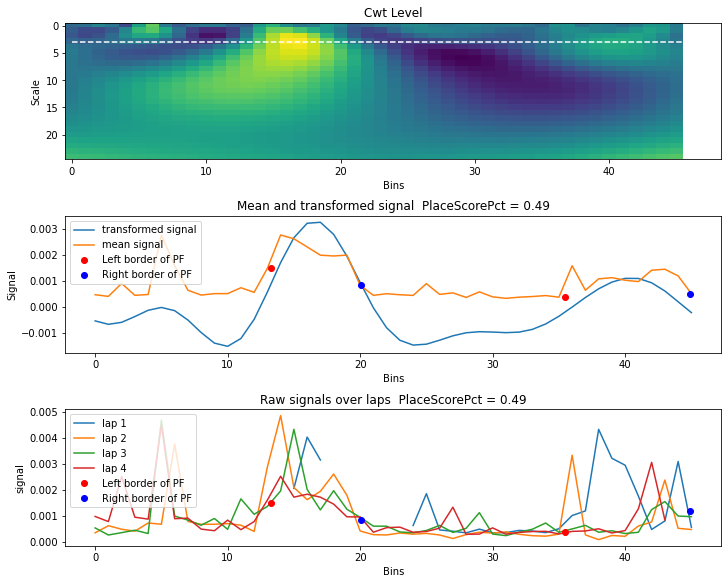

In [19]:
# Plot placefield for single cells

minSmoothingLevel = 0
maxSmoothingLevel = 15
cellIdx = 3

cwtMatr, peakPosition, cwtLevel, placeFieldEdges = determine_placefield(cellIdx,minSmoothingLevel,maxSmoothingLevel)

idxRight = np.array([int(round(x)) for x in placeFieldEdges[1]])
idxLeft = np.array([int(round(x)) for x in placeFieldEdges[0]])

fig = plt.figure(figsize=(10,8),constrained_layout = True)
ax = fig.add_gridspec(3,2)
ax1 = fig.add_subplot(ax[0,0:2])
ax2 = fig.add_subplot(ax[1,0:2])
ax3 = fig.add_subplot(ax[2,0:2])


# Plot wavelet transform for all possible levels in the level range and mark 'optimal' level.
ax1.imshow(cwtMatr[:maxSmoothingLevel+10,numBins:2*numBins],interpolation = 'none',aspect='auto')
ax1.plot(np.linspace(0,numBins,numBins),[cwtLevel]*numBins,color = 'w',linestyle = '--')
ax1.set_title('Cwt Level')
ax1.set_xlabel('Bins')
ax1.set_ylabel('Scale')


# Plot mean position binned signal over all laps and the transformed signal 
ax2.plot(cwtMatr[cwtLevel][numBins:numBins*2],label='transformed signal')
ax2.plot(meanDFFNormalized[cellIdx], label = 'mean signal')
if not np.array(idxRight).size == 0:
    ax2.plot(placeFieldEdges[0],meanDFFNormalized[cellIdx][idxLeft] ,marker = 'o',linestyle = 'None',color='r',\
           label = 'Left border of PF')
    ax2.plot(placeFieldEdges[1],meanDFFNormalized[cellIdx][idxRight] ,marker = 'o',linestyle = 'None',color='b',label\
           = 'Right border of PF')
ax2.legend(loc = 'upper left')
ax2.set_xlabel('Bins')
ax2.set_ylabel('Signal')
ax2.set_title('Mean and transformed signal  PlaceScorePct = '+str(placeScorePct[cellIdx]))


# Plot different laps:
for l in range(0,numLaps):
    ax3.plot(dFFInBinAllNormalized[cellIdx][l],label='lap '+str(l+1))


if not np.array(idxRight).size==0:
    ax3.plot(placeFieldEdges[0],meanDFFNormalized[cellIdx][idxLeft] \
           ,marker = 'o',linestyle = 'None',color='r',\
           label = 'Left border of PF')
    idxRight = [int(x) for x in placeFieldEdges[1]]
    ax3.plot(placeFieldEdges[1],meanDFFNormalized[cellIdx][idxRight] \
           ,marker = 'o',linestyle = 'None',color='b',label \
           = 'Right border of PF')
    
ax3.set_title('Raw signals over laps  PlaceScorePct = '+str(placeScorePct[cellIdx]))
ax3.legend(loc = 'upper left')
ax3.set_xlabel('Bins')
ax3.set_ylabel('signal')



In [20]:
#If placefield was detected: For how many laps is mean in placefields higher than (K times) the mean 
#outside of PF?


K = 1.5

numPlaceCodedLaps = [0]*numCells

for c in range(0,numCells):
    
    inPF = []
    outPF = []
    cwtMatr, peakPosition, cwtLevel, placeFieldEdges = determine_placefield(c,minSmoothingLevel,maxSmoothingLevel)
    idxRight = np.array([int(np.floor(x)) for x in placeFieldEdges[1]])
    idxLeft = np.array([int(np.floor(x)) for x in placeFieldEdges[0]])
    
    for k in range(0,len(idxRight)): # for all place fields per cell

        interval = []
        intervalWidth = idxRight[k]-idxLeft[k]


        #In case the field spans the edge between last and first bin (note circularity of treadmill)
        if intervalWidth <0: 
            interval = np.concatenate((np.linspace(idxLeft[k],numBins-1,numBins-idxLeft[k]),\
                                    np.linspace(0,idxRight[k],idxRight[k]+1)),axis=None)

        else: 
            interval = np.concatenate((np.linspace(idxLeft[k],idxRight[k],idxRight[k]-idxLeft[k]+1)),axis=None)                              

        interval = [int(x) for x in interval]
        inPF = inPF+interval

        for m in range(0,numBins):
            if m not in np.array(inPF).flatten():
                outPF.append(int(m))

    for l in range(0,numLaps):
        if np.nanmean(np.array(dFFInBinAllNormalized)[c][l][inPF]) > \
        K*np.nanmean(np.array(dFFInBinAllNormalized)[c][l][outPF]):
            numPlaceCodedLaps[c]= numPlaceCodedLaps[c]+1

if dFF_flag == True:
    stablePlaceFieldCells_dFF = np.where(np.array(numPlaceCodedLaps)>=np.round(0.8*numLaps))
else:
    stablePlaceFieldCells_S = np.where(np.array(numPlaceCodedLaps)>=np.round(0.8*numLaps))


<ipython-input-20-a700e20ab3a1>:39: RuntimeWarning: Mean of empty slice
  if np.nanmean(np.array(dFFInBinAllNormalized)[c][l][inPF]) > \
<ipython-input-20-a700e20ab3a1>:40: RuntimeWarning: Mean of empty slice
  K*np.nanmean(np.array(dFFInBinAllNormalized)[c][l][outPF]):


In [21]:
# Speed_tuning: Linear regression of dFF as a function of mouse speed plus goodness of fit (i.e.'speedscore'):

widthOfSpeedBin = max(v)/100
print('Width of speed bin = '+str(widthOfSpeedBin)+' cm/s')

speedBin = np.arange((min(v)),(max(v)),widthOfSpeedBin) 
numSpeedBins = len(speedBin)-1
    
def assign_speedBins(dFF_signal):
    
      
    dFFPerSpeedBinNormalized = [0]*numSpeedBins
    
    for b in range(1,numSpeedBins+1):

        BinIdx1 = np.where(v>speedBin[b-1])[0]
        BinIdx = np.where(v<speedBin[b])[0]

        Idx = list(set(BinIdx1).intersection(BinIdx))

        dFFPerSpeedBin = dFF_signal[Idx]
        durPerSpeedBin = len(Idx)
        dFFPerSpeedBinNormalized[b-1] = np.nanmean(dFFPerSpeedBin/durPerSpeedBin)

    
    return dFFPerSpeedBinNormalized    

Width of speed bin = 0.38203695487078076 cm/s


In [22]:
def f(x,a,b):
    f = a*x+b
    return f

def speed_regression(signal,v):
   
    # do linear regression:
    x = v
    y = signal
    popt, pcov = curve_fit(f,x,y)
    
    # compute r2:
    r2 = 1.0-(sum((y-f(x,*popt))**2)/((n-1.0)*np.var(y,ddof=1)))

    
    return popt, pcov, r2
    

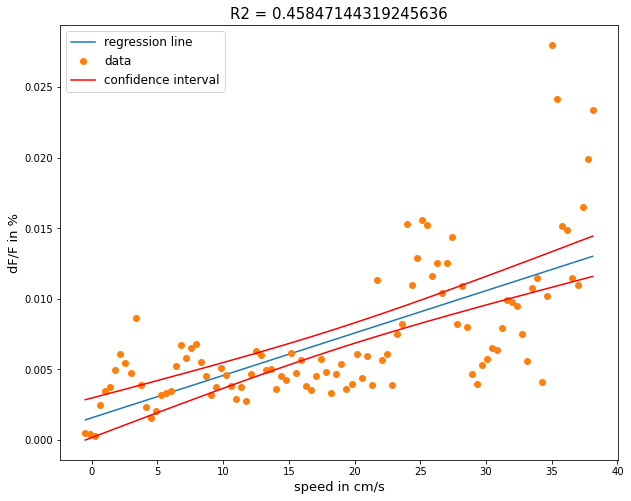

In [23]:
cellIdx = 64

x = speedBin[1:]
speedBinnedSignal = assign_speedBins(dFF[cellIdx])
y = speedBinnedSignal
n = len(y)

popt, pcov, r2 = speed_regression(y,x)


# plotting:
plt.figure(figsize = (10,8))
plt.plot(x,f(x,*popt), label = 'regression line')
plt.plot(x,y,'.',label = 'data',markersize = 12)
plt.title('R2 = '+ str(r2), fontsize = 15)
plt.xlabel('speed in cm/s' , fontsize = 13)
plt.ylabel('dF/F in %', fontsize = 13)

# compute the confidence intervals:

a,b = unc.correlated_values(popt, pcov)
std = unp.std_devs(f(x,a,b))
nom = unp.nominal_values(f(x,a,b))
plt.plot(x, nom + 1.96 * std, c='red', label = 'confidence interval')
plt.plot(x, nom - 1.96 * std, c='red')


plt.legend(fontsize = 12)
plt.show()

In [24]:
# Check R2 for all cells
x = speedBin[1:]
r2 = [0]*numCells
for c in range(0,numCells):
    
    speedBinnedSignal = assign_speedBins(dFF[c])
    y = speedBinnedSignal
    n = len(y)
    _, _, r2[c] = speed_regression(y,x)

Text(0.5, 0, 'cell')

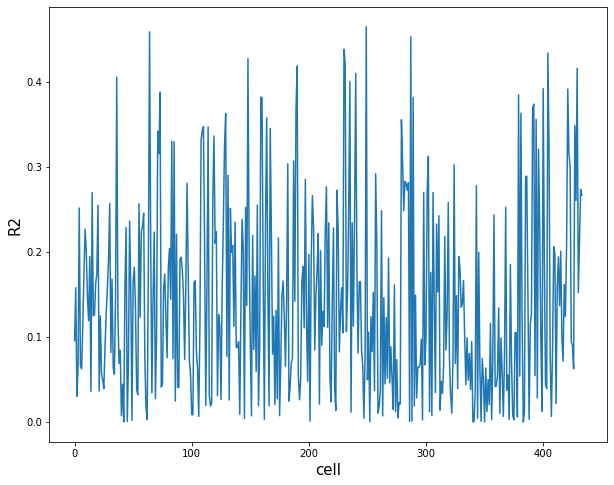

In [25]:
#plot speed R2
plt.figure(figsize=(10,8))
plt.plot(r2)
plt.ylabel('R2', fontsize = 15)
plt.xlabel('cell', fontsize = 15)

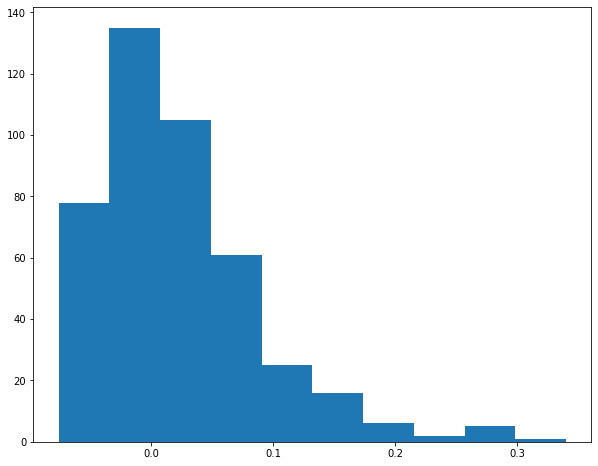

In [41]:
# place score and speed score as a function of the number of neurons: 

#plt.hist(r2)
fig = plt.figure(figsize = (10,8))
ax = fig.add_gridspec(2,1)
plt.hist(placeScore)
plt.show()